<a href="https://colab.research.google.com/github/Ravikrishnan05/PrediscanMedtech_project/blob/main/final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# ==============================================================================
# FINAL SETUP CELL: Corrected Installs, Imports, and Data Preparation
#
# INSTRUCTIONS:
# 1. Run this single cell and wait. It will take 3-5 minutes.
# 2. DO NOT INTERRUPT IT. Wait for the final "ALL SETUP STEPS COMPLETE!" message.
# 3. You will be prompted to authorize Google Drive access.
# ==============================================================================

# --- STEP 1 of 4: Installing all required libraries (CORRECTED) ---
print("--- STEP 1 of 4: Installing all required libraries ---")
print("This uses the official Unsloth command which now correctly handles new dependencies.")

# The official Unsloth command is sufficient. It will install a compatible version
# of bitsandbytes, triton, and other libraries. We do NOT need to pin old versions.
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# Install other project-specific libraries
!pip install -q "pydicom" "pandas" "scikit-learn" "seaborn"
print("✅ Libraries installed successfully.\n")

--- STEP 1 of 4: Installing all required libraries ---
This uses the official Unsloth command which now correctly handles new dependencies.
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-8ol4mc_j/unsloth_3b3573d4df75420db1f70e5ad84e09de
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-8ol4mc_j/unsloth_3b3573d4df75420db1f70e5ad84e09de
  Resolved https://github.com/unslothai/unsloth.git to commit 73dd1227b09ab5e4d8a151e15410a643c99a1e82
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.0/130.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

In [8]:
# --- STEP 2 of 4: Importing all libraries in the correct order ---
print("--- STEP 2 of 4: Importing all libraries ---")
# Unsloth must be imported before Transformers
import torch
from unsloth import FastVisionModel

# Standard Python libraries
import os
import shutil
import zipfile

# Data handling and processing libraries
import pandas as pd
import numpy as np
import pydicom
from PIL import Image
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import transformers
import sklearn

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Google Colab specific
from google.colab import drive

# Set a random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("✅ Libraries imported successfully.\n")


# --- STEP 3 of 4: Mounting Google Drive ---
print("--- STEP 3 of 4: Mounting Google Drive ---")
print("Please authorize access when prompted.")
try:
    drive.mount('/content/drive', force_remount=True)
    print("✅ Google Drive mounted successfully.\n")
except Exception as e:
    print(f"❌ ERROR mounting Google Drive: {e}")


# --- STEP 4 of 4: Unpacking data to the local Colab environment ---
print("--- STEP 4 of 4: Unpacking data from Drive to local storage ---")

# Define all file paths
DRIVE_CSV_PATH = "/content/drive/MyDrive/cp.csv"
DRIVE_ZIP_PATH = "/content/drive/MyDrive/1000-20250517T062750Z-1-001.zip"
LOCAL_EXTRACT_PATH = "/content/extracted_images"
LOCAL_IMAGES_ROOT = os.path.join(LOCAL_EXTRACT_PATH, "1000")
LOCAL_CSV_PATH = "/content/cp.csv"

# Copy CSV
if os.path.exists(DRIVE_CSV_PATH):
    shutil.copy(DRIVE_CSV_PATH, LOCAL_CSV_PATH)
    print(f"✅ CSV file copied to: {LOCAL_CSV_PATH}")
else:
    print(f"❌ ERROR: CSV file not found at {DRIVE_CSV_PATH}")

# Unzip Images
if os.path.exists(DRIVE_ZIP_PATH):
    if os.path.exists(LOCAL_EXTRACT_PATH):
        shutil.rmtree(LOCAL_EXTRACT_PATH)
    os.makedirs(LOCAL_EXTRACT_PATH, exist_ok=True)
    print(f"Unzipping images to {LOCAL_EXTRACT_PATH}...")
    with zipfile.ZipFile(DRIVE_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(LOCAL_EXTRACT_PATH)
    print("✅ Images unzipped successfully.")
else:
    print(f"❌ ERROR: ZIP file not found at {DRIVE_ZIP_PATH}")

print("\n\n======================================================================")
print("✅ ALL SETUP STEPS COMPLETE! You can now proceed with your project.")
print("======================================================================")

--- STEP 2 of 4: Importing all libraries ---
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
✅ Libraries imported successfully.

--- STEP 3 of 4: Mounting Google Drive ---
Please authorize access when prompted.
Mounted at /content/drive
✅ Google Drive mounted successfully.

--- STEP 4 of 4: Unpacking data from Drive to local storage ---
✅ CSV file copied to: /content/cp.csv
Unzipping images to /content/extracted_images...
✅ Images unzipped successfully.


✅ ALL SETUP STEPS COMPLETE! You can now proceed with your project.


In [9]:
# ==============================================================================
# NEW CELL 2 (Using Your Proven, More Accurate Logic)
# ==============================================================================
print("--- Loading and Preparing Data Using Your Proven Multi-Image Logic ---")

# --- Step 1: Load and clean the clinical data ---
df_clinical = pd.read_csv(LOCAL_CSV_PATH)
print(f"Loaded {len(df_clinical)} raw records from {LOCAL_CSV_PATH}.")

# Define column names to use
person_id_col = 'person_id'  # The ID column in your cp.csv
ldl_col = 'LDL Cholesterol Calculation (mg/dL)'  # The target column

# Clean the clinical data
df_clinical.rename(columns={ldl_col: 'LDL_temp'}, inplace=True)
df_clinical['LDL_temp'] = pd.to_numeric(df_clinical['LDL_temp'], errors='coerce')
df_clinical.dropna(subset=['LDL_temp'], inplace=True)
df_clinical = df_clinical[df_clinical['LDL_temp'] > 0].copy()
df_clinical[person_id_col] = df_clinical[person_id_col].astype(str)
print(f"Found {len(df_clinical)} clinically valid records (positive LDL).")

# Create lookup dictionary for LDL values
ldl_lookup = df_clinical.set_index(person_id_col)['LDL_temp'].to_dict()

# --- Step 2: Scan and match DICOM images ---
image_records = []
valid_person_ids = set(ldl_lookup.keys())

print(f"Scanning for all matching DICOM files in {LOCAL_IMAGES_ROOT}...")
for person_id_str in os.listdir(LOCAL_IMAGES_ROOT):
    if person_id_str in valid_person_ids:
        folder_path = os.path.join(LOCAL_IMAGES_ROOT, person_id_str)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(".dcm"):
                    image_path = os.path.join(folder_path, filename)
                    image_records.append({
                        "person_id": person_id_str,
                        "image_path": image_path,
                        "ldl_c": ldl_lookup[person_id_str]
                    })

# Create final DataFrame
image_df = pd.DataFrame(image_records)

if image_df.empty:
    raise RuntimeError("CRITICAL ERROR: No image-LDL pairs were found. Check paths and IDs.")
else:
    print(f"\nSuccessfully created a DataFrame with {len(image_df)} image-LDL pairs.")
    print("This correctly includes multiple images for the same person.")

# --- Step 3: Normalize LDL values and split dataset ---
target_column = 'ldl_c'
scaler = StandardScaler()
image_df[f'{target_column}_scaled'] = scaler.fit_transform(image_df[[target_column]])
print(f"\nTarget variable '{target_column}' has been scaled.")

# Train/Val/Test Split
train_df, temp_df = train_test_split(image_df, test_size=0.3, random_state=RANDOM_SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_SEED)

print("\n--- Final Data Split ---")
print(f"Training samples:   {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples:       {len(test_df)}")
print("------------------------\n")

print("✅ Data preparation with YOUR proven logic is complete.")

--- Loading and Preparing Data Using Your Proven Multi-Image Logic ---
Loaded 1067 raw records from /content/cp.csv.
Found 1025 clinically valid records (positive LDL).
Scanning for all matching DICOM files in /content/extracted_images/1000...

Successfully created a DataFrame with 973 image-LDL pairs.
This correctly includes multiple images for the same person.

Target variable 'ldl_c' has been scaled.

--- Final Data Split ---
Training samples:   681
Validation samples: 146
Test samples:       146
------------------------

✅ Data preparation with YOUR proven logic is complete.


In [ ]:
#make print some data in the data frame
print(train_df.head())
print(val_df.head())
print(test_df.head())

    person_id                                         image_path      ldl_c  \
514      7065  /content/extracted_images/1000/7065/7065_eidon...  33.433661   
583      7135  /content/extracted_images/1000/7135/7135_eidon...  66.071719   
926      4081  /content/extracted_images/1000/4081/4081_eidon...  45.120156   
850      7078  /content/extracted_images/1000/7078/7078_eidon...  77.174672   
423      1048  /content/extracted_images/1000/1048/1048_eidon...  73.187087   

     ldl_c_scaled  
514     -1.632178  
583     -0.726669  
926     -1.307948  
850     -0.418630  
423     -0.529261  
    person_id                                         image_path      ldl_c  \
559      7279  /content/extracted_images/1000/7279/7279_eidon...  79.873221   
235      1222  /content/extracted_images/1000/1222/1222_eidon...  65.680378   
736      7283  /content/extracted_images/1000/7283/7283_eidon...  84.211844   
740      1250  /content/extracted_images/1000/1250/1250_eidon...  68.666123   
479      1

In [10]:
# ==============================================================================
# NEW CELL 3: Load MedGemma Model and Processor
# ==============================================================================
print("--- Loading Pre-trained MedGemma Model ---")

# Define the model we want to use
model_name = "google/medgemma-4b-pt"

# Load the model and its processor with Unsloth for 4-bit quantization
model, processor = FastVisionModel.from_pretrained(
    model_name,
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)

# Automatically determine the vision feature dimension
if hasattr(model.config, 'vision_config') and hasattr(model.config.vision_config, 'hidden_size'):
    vision_feature_dim = model.config.vision_config.hidden_size
else:
    vision_feature_dim = 1152 # Fallback for MedGemma

print(f"\nModel '{model_name}' loaded successfully.")
print(f"Vision feature dimension detected: {vision_feature_dim}")
print("✅ Model loading complete.")

--- Loading Pre-trained MedGemma Model ---
==((====))==  Unsloth 2025.8.10: Fast Gemma3 patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]


Model 'google/medgemma-4b-pt' loaded successfully.
Vision feature dimension detected: 1152
✅ Model loading complete.


In [11]:
# ==============================================================================
# NEW CELL 4: Create Custom PyTorch Dataset and DataLoaders
# ==============================================================================
print("--- Defining DICOM Dataset and Creating DataLoaders ---")

class DicomRegressionDataset(Dataset):
    """Custom PyTorch Dataset for loading DICOM images and their regression targets."""
    def __init__(self, dataframe, processor, target_col_scaled):
        self.df = dataframe
        self.processor = processor
        self.target_col_scaled = target_col_scaled

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']
        try:
            dicom_file = pydicom.dcmread(image_path)
            pixel_array = dicom_file.pixel_array
            pixel_array = ((pixel_array - np.min(pixel_array)) / (np.max(pixel_array) - np.min(pixel_array)) * 255.0).astype(np.uint8)
            pil_image = Image.fromarray(pixel_array).convert('RGB')
        except Exception as e:
            print(f"Error loading or processing DICOM file at {image_path}: {e}")
            pil_image = Image.new('RGB', (224, 224), color = 'red')

        processed_output = self.processor.image_processor(images=pil_image, return_tensors="pt")
        pixel_values = processed_output.pixel_values.squeeze(0) # Remove batch dimension
        target = torch.tensor(row[self.target_col_scaled], dtype=torch.float32)
        return pixel_values, target

# Create Datasets
train_dataset = DicomRegressionDataset(train_df, processor, f'{target_column}_scaled')
val_dataset = DicomRegressionDataset(val_df, processor, f'{target_column}_scaled')
test_dataset = DicomRegressionDataset(test_df, processor, f'{target_column}_scaled')

# Create DataLoaders
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nDatasets and DataLoaders created with batch size {BATCH_SIZE}.")
print("✅ Dataset setup complete.")

--- Defining DICOM Dataset and Creating DataLoaders ---

Datasets and DataLoaders created with batch size 8.
✅ Dataset setup complete.


In [12]:
# ==============================================================================
# NEW CELL 5 (Corrected for Dtype Mismatch)
# ==============================================================================
print("--- Defining Regressor Model and Training Components (with Dtype fix) ---")

class MedGemmaVisionRegressor(nn.Module):
    """A wrapper to use MedGemma's vision tower for a regression task."""
    def __init__(self, base_vlm_model, vision_feature_dim_input: int):
        super().__init__()
        self.base_vlm = base_vlm_model
        # We explicitly define our regression head to work in float32 for stability.
        self.target_dtype = torch.float32

        self.regression_head = nn.Sequential(
            nn.Linear(vision_feature_dim_input, vision_feature_dim_input // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(vision_feature_dim_input // 2, 1)
        ).to(dtype=self.target_dtype)

    def forward(self, pixel_values: torch.Tensor):
        # The input pixel_values from the DataLoader are already float32.
        # No change needed here for the vision_tower input itself.

        # We only need the vision tower for this task.
        vision_outputs = self.base_vlm.vision_tower(pixel_values=pixel_values.to(torch.bfloat16), return_dict=True)

        # The output of the vision tower (image_features) is float16/bfloat16.
        if hasattr(vision_outputs, "last_hidden_state"):
            image_features = vision_outputs.last_hidden_state[:, 0, :]
        else:
            raise RuntimeError("Could not extract vision features from the vision tower output.")

        # ====================================================================
        # THE FIX IS HERE:
        # Convert the image_features to match the dtype of the regression head.
        # ====================================================================
        image_features = image_features.to(self.target_dtype)

        prediction = self.regression_head(image_features)
        return prediction

# --- Instantiate Model and Training Components (No changes here) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regressor_model = MedGemmaVisionRegressor(model, vision_feature_dim)
regressor_model.to(device)

loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(regressor_model.parameters(), lr=5e-5)

print("\nFull Regressor Model Architecture:")
print(regressor_model)
print(f"\nModel moved to: {device}")

print("\nTrainable parameters:")
for name, param in regressor_model.named_parameters():
    if param.requires_grad:
        print(f"  - {name} (Shape: {param.shape})")

print("\n✅ Model and training components are ready for training.")

--- Defining Regressor Model and Training Components (with Dtype fix) ---

Full Regressor Model Architecture:
MedGemmaVisionRegressor(
  (base_vlm): Gemma3ForConditionalGeneration(
    (model): Gemma3Model(
      (vision_tower): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(4096, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                (self_attn): SiglipAttention(
                  (k_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                  (v_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                  (q_proj): Linear4bit(in_features=1152, out_fe

In [ ]:
# ==============================================================================
# NEW CELL 6: The Training & Validation Loop
# ==============================================================================
print("--- Starting Model Training ---")
NUM_EPOCHS = 10 # You can adjust this. 10 is a good starting point.
best_val_loss = float('inf')
output_dir = "/content/drive/MyDrive/medgemma_ldl_output"
os.makedirs(output_dir, exist_ok=True)


for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    regressor_model.train()
    total_train_loss = 0
    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")

    for batch_pixel_values, batch_targets in train_progress_bar:
        batch_pixel_values = batch_pixel_values.to(device)
        batch_targets = batch_targets.to(device)

        optimizer.zero_grad()
        predictions = regressor_model(batch_pixel_values)
        loss = loss_function(predictions.squeeze(), batch_targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)

    # --- Validation Phase ---
    regressor_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for batch_pixel_values, batch_targets in val_progress_bar:
            batch_pixel_values = batch_pixel_values.to(device)
            batch_targets = batch_targets.to(device)

            predictions = regressor_model(batch_pixel_values)
            loss = loss_function(predictions.squeeze(), batch_targets)
            total_val_loss += loss.item()
            val_progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model_save_path = os.path.join(output_dir, "best_medgemma_regressor.pth")
        torch.save(regressor_model.state_dict(), model_save_path)
        print(f"** New best model saved to {model_save_path} with validation loss: {best_val_loss:.4f} **\n")

print("--- Training Complete! ---")

--- Starting Model Training ---


Epoch 1/10 [Val]: 100%|██████████| 19/19 [01:24<00:00,  4.44s/it, loss=4.0193]


Epoch 1/10 -> Train Loss: 0.9976 | Validation Loss: 1.2576
** New best model saved to /content/drive/MyDrive/medgemma_ldl_output/best_medgemma_regressor.pth with validation loss: 1.2576 **



Epoch 2/10 [Val]: 100%|██████████| 19/19 [01:23<00:00,  4.41s/it, loss=4.1084]


Epoch 2/10 -> Train Loss: 0.9597 | Validation Loss: 1.2408
** New best model saved to /content/drive/MyDrive/medgemma_ldl_output/best_medgemma_regressor.pth with validation loss: 1.2408 **



Epoch 3/10 [Val]: 100%|██████████| 19/19 [01:28<00:00,  4.63s/it, loss=4.0821]


Epoch 3/10 -> Train Loss: 0.9577 | Validation Loss: 1.2362
** New best model saved to /content/drive/MyDrive/medgemma_ldl_output/best_medgemma_regressor.pth with validation loss: 1.2362 **



Epoch 4/10 [Val]: 100%|██████████| 19/19 [01:24<00:00,  4.44s/it, loss=4.1123]


Epoch 4/10 -> Train Loss: 0.9702 | Validation Loss: 1.2353
** New best model saved to /content/drive/MyDrive/medgemma_ldl_output/best_medgemma_regressor.pth with validation loss: 1.2353 **



Epoch 5/10 [Val]: 100%|██████████| 19/19 [01:24<00:00,  4.43s/it, loss=4.1505]


Epoch 5/10 -> Train Loss: 0.9539 | Validation Loss: 1.2273
** New best model saved to /content/drive/MyDrive/medgemma_ldl_output/best_medgemma_regressor.pth with validation loss: 1.2273 **



Epoch 6/10 [Val]: 100%|██████████| 19/19 [01:23<00:00,  4.39s/it, loss=3.9134]


Epoch 6/10 -> Train Loss: 0.9405 | Validation Loss: 1.2360


Epoch 7/10 [Val]: 100%|██████████| 19/19 [01:23<00:00,  4.42s/it, loss=3.8797]


Epoch 7/10 -> Train Loss: 0.9185 | Validation Loss: 1.2434


Epoch 8/10 [Val]: 100%|██████████| 19/19 [01:23<00:00,  4.38s/it, loss=3.8197]


Epoch 8/10 -> Train Loss: 0.9146 | Validation Loss: 1.3057


Epoch 9/10 [Val]: 100%|██████████| 19/19 [01:20<00:00,  4.25s/it, loss=3.9484]


Epoch 9/10 -> Train Loss: 0.9385 | Validation Loss: 1.2221
** New best model saved to /content/drive/MyDrive/medgemma_ldl_output/best_medgemma_regressor.pth with validation loss: 1.2221 **



Epoch 10/10 [Val]: 100%|██████████| 19/19 [01:26<00:00,  4.56s/it, loss=3.8437]

Epoch 10/10 -> Train Loss: 0.9236 | Validation Loss: 1.2598
--- Training Complete! ---


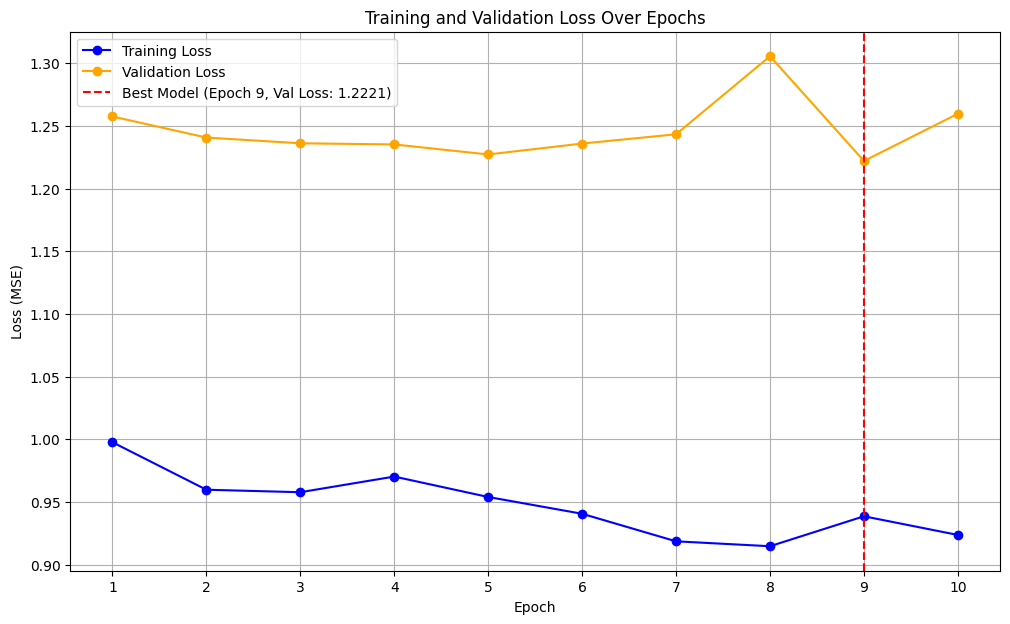

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# --- Extract the data from your training log ---
epochs = np.arange(1, 11)
train_losses = [
    0.9976,
    0.9597,
    0.9577,
    0.9702,
    0.9539,
    0.9405,
    0.9185,
    0.9146,
    0.9385,
    0.9236
]
val_losses = [
    1.2576,
    1.2408,
    1.2362,
    1.2353,
    1.2273,
    1.2360,
    1.2434,
    1.3057,
    1.2221,
    1.2598
]

# --- Create the plot ---
plt.figure(figsize=(12, 7))
plt.plot(epochs, train_losses, 'o-', label='Training Loss', color='blue')
plt.plot(epochs, val_losses, 'o-', label='Validation Loss', color='orange')

# Find the best epoch
best_epoch = np.argmin(val_losses) + 1
best_val_loss = np.min(val_losses)
plt.axvline(x=best_epoch, color='r', linestyle='--',
            label=f'Best Model (Epoch {best_epoch}, Val Loss: {best_val_loss:.4f})')

# --- Add labels and title for clarity ---
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.xticks(epochs) # Ensure we have a tick for each epoch
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
"""
# -----------------------------------------------------------------------------
# Cell 3: Load Data Manifest, Preprocess, and Split
# -----------------------------------------------------------------------------
print("--- 3. Loading and Preparing Data ---")

# --- Load the CSV ---
df = pd.read_csv(LOCAL_CSV_PATH)
print(f"Loaded {LOCAL_CSV_PATH} with {len(df)} records.")
print("Original DataFrame info:")
df.info()
print("\nFirst 5 rows:")
print(df.head())

# --- Preprocessing ---
# 1. Construct full image paths
# The CSV has a 'person_id' column (e.g., 1001, 1002, 1003) which corresponds to the DICOM filename (e.g., 1.dcm)
df['image_path'] = df['person_id'].apply(lambda x: os.path.join(LOCAL_IMAGES_ROOT, f"{x}.dcm"))

# 2. Check for missing target values and handle them
target_column = 'LDL Cholesterol Calculation (mg/dL)'
print(f"\nChecking for missing values in target column '{target_column}'...")
initial_rows = len(df)
df.dropna(subset=[target_column], inplace=True)
print(f"Removed {initial_rows - len(df)} rows with missing '{target_column}' values.")
print(f"Remaining records: {len(df)}")


# 3. Normalize the target variable (Crucial for stable training)
# We use StandardScaler to transform 'ldl_c' to have a mean of 0 and std dev of 1.
# We must save the scaler to inverse-transform the predictions later to see real values.
scaler = StandardScaler()
df[f'{target_column}_scaled'] = scaler.fit_transform(df[[target_column]])
print(f"\nTarget variable '{target_column}' has been scaled.")
print("Description of original and scaled target:")
print(df[[target_column, f'{target_column}_scaled']].describe())


# --- Split Data (70% train, 15% validation, 15% test) ---
train_df, temp_df = train_test_split(
    df,
    test_size=0.3, # 30% left for val and test
    random_state=RANDOM_SEED
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5, # Split the 30% into 15% val and 15% test
    random_state=RANDOM_SEED
)

print("\n--- Data Split ---")
print(f"Training samples:   {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples:       {len(test_df)}")
print("--------------------\n")

print("Cell 3: Data preparation complete.")
"""

--- 3. Loading and Preparing Data ---
Loaded /content/cp.csv with 1067 records.
Original DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Columns: 111 entries, person_id to whr_vsorres, Waist to Hip Ratio (WHR)
dtypes: float64(107), int64(4)
memory usage: 925.4 KB

First 5 rows:
   person_id  A/G Ratio  ALT (IU/L)  AST (IU/L)  Albumin (g/dL)  \
0       1001        2.1        11.0        17.0             4.5   
1       1002        1.4        20.0        23.0             4.4   
2       1003        1.6        16.0        15.0             4.4   
3       1004        2.0        15.0        10.0             4.3   
4       1005        1.4        21.0        22.0             4.1   

   Alkaline Phosphatase (IU/L)  BUN (mg/dL)  BUN/Creatinine ratio  \
0                         53.0         19.0             23.170732   
1                         65.0         12.0             15.789474   
2                         53.0         16.0             19.512195   


In [14]:
# ==============================================================================
# NEW CELL: Imports and Setup for Testing
# ==============================================================================
print("--- Setting up for testing ---")
import torch
import torch.nn as nn
from unsloth import FastLanguageModel
from transformers import AutoProcessor
from torch.utils.data import Dataset, DataLoader
import pydicom
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Ensure you have the same device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

--- Setting up for testing ---
Using device: cuda


In [15]:
# ==============================================================================
# NEW CELL: Re-create the Model Architecture
# ==============================================================================
print("--- Re-initializing the full model architecture ---")

# --- Step 1: Load the base MedGemma model using Unsloth (for 4-bit quantization) ---
base_model, processor = FastLanguageModel.from_pretrained(
    model_name = "google/medgemma-4b-pt",
    max_seq_length = 2048,
    dtype = None, # Unsloth will handle dtype selection
    load_in_4bit = True,
)
vision_feature_dim = base_model.config.vision_config.hidden_size
print(f"Base model loaded. Vision feature dimension: {vision_feature_dim}")


# --- Step 2: Copy the EXACT SAME Regressor Class Definition ---
class MedGemmaVisionRegressor(nn.Module):
    """A wrapper to use MedGemma's vision tower for a regression task."""
    def __init__(self, base_vlm_model, vision_feature_dim_input: int):
        super().__init__()
        self.base_vlm = base_vlm_model
        self.target_dtype = torch.float32

        self.regression_head = nn.Sequential(
            nn.Linear(vision_feature_dim_input, vision_feature_dim_input // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(vision_feature_dim_input // 2, 1)
        ).to(dtype=self.target_dtype)

    def forward(self, pixel_values: torch.Tensor):
        vision_outputs = self.base_vlm.vision_tower(pixel_values=pixel_values.to(torch.bfloat16), return_dict=True)
        if hasattr(vision_outputs, "last_hidden_state"):
            image_features = vision_outputs.last_hidden_state[:, 0, :]
        else:
            raise RuntimeError("Could not extract vision features from the vision tower output.")
        image_features = image_features.to(self.target_dtype)
        prediction = self.regression_head(image_features)
        return prediction

# --- Step 3: Instantiate the full regressor model ---
regressor_model = MedGemmaVisionRegressor(base_model, vision_feature_dim)
regressor_model.to(device)

print("\n✅ Model architecture re-created successfully.")
print(regressor_model)

--- Re-initializing the full model architecture ---
==((====))==  Unsloth 2025.8.10: Fast Gemma3 patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Base model loaded. Vision feature dimension: 1152

✅ Model architecture re-created successfully.
MedGemmaVisionRegressor(
  (base_vlm): Gemma3ForConditionalGeneration(
    (model): Gemma3Model(
      (vision_tower): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(4096, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                (self_attn): SiglipAttention(
                  (k_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                  (v_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                  (q_proj): Linear4bit(in_features=1152, out_features=1152, 

In [18]:
# ==============================================================================
# NEW CELL: Load Best Model Weights (Corrected Method)
# ==============================================================================
print("--- Loading Best Trained Model Weights (Robust Method) ---")

# The path is to your FULL saved model state
model_save_path = "/content/drive/MyDrive/MedGemma_LDL_Checkpoints/best_medgemma_regressor.pth"

# Check if the model file exists
if os.path.exists(model_save_path):
    # Load the entire state dictionary from the file into memory (CPU)
    full_state_dict = torch.load(model_save_path, map_location='cpu')

    # ============================================================================
    # THE FIX: Isolate the state_dict for the regression_head ONLY.
    # We create a new dictionary containing only the keys that start with
    # 'regression_head.' and we strip that prefix off.
    # ============================================================================
    regression_head_state_dict = {
        key.replace("regression_head.", ""): value
        for key, value in full_state_dict.items()
        if key.startswith("regression_head.")
    }

    # Now, load this clean, small state dictionary into the regression head.
    # This is the correct and robust way to do it. `strict=True` will work here.
    regressor_model.regression_head.load_state_dict(regression_head_state_dict)

    # Move the entire model back to the correct device
    regressor_model.to(device)

    print(f"✅ Regression head weights loaded successfully from {model_save_path}")

else:
    print(f"❌ ERROR: Best model weights not found at {model_save_path}")

print("--- Model is ready for evaluation. ---")

--- Loading Best Trained Model Weights (Robust Method) ---
✅ Regression head weights loaded successfully from /content/drive/MyDrive/MedGemma_LDL_Checkpoints/best_medgemma_regressor.pth
--- Model is ready for evaluation. ---


In [19]:
# ==============================================================================
# NEW CELL: Evaluate the Model on the Test Set
# ==============================================================================
print("--- Starting evaluation on the test set ---")

# Set the model to evaluation mode
regressor_model.eval()

all_predictions_scaled = []
all_targets_scaled = []

# Disable gradient calculations for inference
with torch.no_grad():
    test_progress_bar = tqdm(test_loader, desc="Testing")
    for batch_pixel_values, batch_targets in test_progress_bar:
        # Move data to the device
        batch_pixel_values = batch_pixel_values.to(device)
        batch_targets = batch_targets.to(device)

        # Get model predictions
        predictions = regressor_model(batch_pixel_values)

        # Store predictions and targets
        all_predictions_scaled.extend(predictions.squeeze().cpu().numpy())
        all_targets_scaled.extend(batch_targets.cpu().numpy())

# Convert lists to numpy arrays for easier calculations
all_predictions_scaled = np.array(all_predictions_scaled)
all_targets_scaled = np.array(all_targets_scaled)

# --- Inverse Transform to Original Scale ---
# IMPORTANT: Replace `scaler` with the actual name of your scaler object (e.g., `min_max_scaler`).
all_predictions_orig = scaler.inverse_transform(all_predictions_scaled.reshape(-1, 1)).flatten()
all_targets_orig = scaler.inverse_transform(all_targets_scaled.reshape(-1, 1)).flatten()


# --- Calculate Metrics ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(all_targets_orig, all_predictions_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_targets_orig, all_predictions_orig)
r2 = r2_score(all_targets_orig, all_predictions_orig)

print("\n--- Test Set Evaluation Results ---")
print(f"Mean Squared Error (MSE):      {mse:.4f}")
print(f"Root Mean Squared Error (RMSE):  {rmse:.4f}")
print(f"Mean Absolute Error (MAE):     {mae:.4f}")
print(f"R-squared (R²):                {r2:.4f}")
print("-------------------------------------")

--- Starting evaluation on the test set ---


Testing: 100%|██████████| 19/19 [02:12<00:00,  6.98s/it]


--- Test Set Evaluation Results ---
Mean Squared Error (MSE):      1405.0134
Root Mean Squared Error (RMSE):  37.4835
Mean Absolute Error (MAE):     28.0204
R-squared (R²):                -0.0053
-------------------------------------


In [20]:
print(f"Total number of images in the test set: {len(test_df)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Calculated number of batches: {np.ceil(len(test_df) / BATCH_SIZE)}")

Total number of images in the test set: 146
Batch size: 8
Calculated number of batches: 19.0


In [ ]:
# ==============================================================================
# NEW CELL: Evaluate the Model on the Test Set
# ==============================================================================
print("--- Starting evaluation on the test set ---")

# Set the model to evaluation mode
regressor_model.eval()

all_predictions_scaled = []
all_targets_scaled = []

# Disable gradient calculations for inference
with torch.no_grad():
    test_progress_bar = tqdm(test_loader, desc="Testing")
    for batch_pixel_values, batch_targets in test_progress_bar:
        # Move data to the device
        batch_pixel_values = batch_pixel_values.to(device)
        batch_targets = batch_targets.to(device)

        # Get model predictions
        predictions = regressor_model(batch_pixel_values)

        # Store predictions and targets
        # .squeeze() removes the extra dimension, .cpu() moves to CPU for numpy conversion
        all_predictions_scaled.extend(predictions.squeeze().cpu().numpy())
        all_targets_scaled.extend(batch_targets.cpu().numpy())

# Convert lists to numpy arrays for easier calculations
all_predictions_scaled = np.array(all_predictions_scaled)
all_targets_scaled = np.array(all_targets_scaled)

# --- Inverse Transform to Original Scale ---
# IMPORTANT: You must have your 'scaler' object from the data preparation phase.
# This was used to create the '{target_column}_scaled' column.
# Replace `scaler` with the actual name of your scaler object (e.g., `min_max_scaler`).

# Assuming your scaler expects a 2D array, we reshape
all_predictions_orig = scaler.inverse_transform(all_predictions_scaled.reshape(-1, 1)).flatten()
all_targets_orig = scaler.inverse_transform(all_targets_scaled.reshape(-1, 1)).flatten()


# --- Calculate Metrics ---
mse = mean_squared_error(all_targets_orig, all_predictions_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_targets_orig, all_predictions_orig)
r2 = r2_score(all_targets_orig, all_predictions_orig)

print("\n--- Test Set Evaluation Results ---")
print(f"Mean Squared Error (MSE):      {mse:.4f}")
print(f"Root Mean Squared Error (RMSE):  {rmse:.4f}")
print(f"Mean Absolute Error (MAE):     {mae:.4f}")
print(f"R-squared (R²):                {r2:.4f}")
print("-------------------------------------")

# New Section